## FCNN Classification Model
#### Predicting all initial 114 genres.

### Import Packages

In [1]:
# tensorflow model imports
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils

# keras imports
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

# sklearn modeling imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import AffinityPropagation, KMeans, SpectralClustering

# other imports
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/spotify_tracks_genre.csv')

### Preprocessing

In [4]:
data = data.drop(labels = ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'],
                 axis = 1)

data["explicit"] = data["explicit"].replace({True:1, False:0})

# adding one-hot encoding of our categorical column time signature and key
data = pd.get_dummies(data, columns = ["time_signature","key"])

In [5]:
data

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,73,230666,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,...,0,0,0,0,0,0,0,0,0,0
1,55,149610,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,...,0,0,0,0,0,0,0,0,0,0
2,57,210826,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,71,201933,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,...,0,0,0,0,0,0,0,0,0,0
4,82,198853,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.2350,-16.393,1,0.0422,0.6400,0.928000,...,0,0,0,1,0,0,0,0,0,0
113996,22,385000,0,0.174,0.1170,-18.318,0,0.0401,0.9940,0.976000,...,0,0,0,0,0,0,0,0,0,0
113997,22,271466,0,0.629,0.3290,-10.895,0,0.0420,0.8670,0.000000,...,0,0,0,0,0,0,0,0,0,0
113998,41,283893,0,0.587,0.5060,-10.889,1,0.0297,0.3810,0.000000,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# train test split
X = data.drop(labels=['track_genre'], axis=1)
y = data['track_genre']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

n = int(len(data)/1000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model Construction

In [7]:
# FCNN model
num_features = X_train.shape[1]
num_genres = np.unique(y_train).shape[0]

def create_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(512, activation=activation, input_shape=(num_features,)))
    model.add(Dense(256, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = activation))
    model.add(Dense(num_genres, activation = 'softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               15872     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 114)               14706     
                                                        

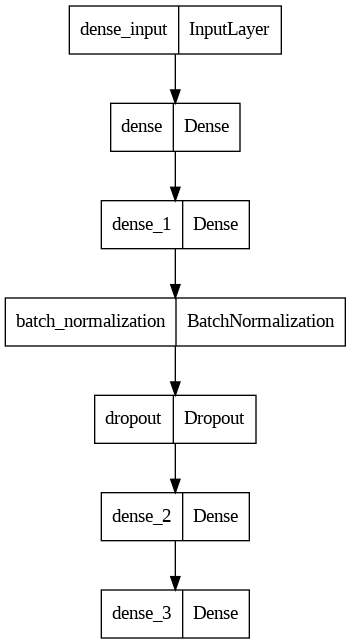

In [9]:
utils.plot_model(model)

### Training

In [10]:
# scheduler to fine tune model learning
def scheduler(epoch, lr):
  return lr*0.9

callback = keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(X_train, y_train, batch_size = 32, verbose=1, epochs=20,
           validation_split=0.1, callbacks = [callback])

Epoch 1/20
2565/2565 [==============================] - 21s 7ms/step - loss: 3.5486 - accuracy: 0.1497 - val_loss: 3.2241 - val_accuracy: 0.2021 - lr: 9.0000e-04
Epoch 2/20
2565/2565 [==============================] - 16s 6ms/step - loss: 3.1585 - accuracy: 0.2101 - val_loss: 3.0165 - val_accuracy: 0.2305 - lr: 8.1000e-04
Epoch 3/20
2565/2565 [==============================] - 16s 6ms/step - loss: 2.9903 - accuracy: 0.2393 - val_loss: 2.8609 - val_accuracy: 0.2635 - lr: 7.2900e-04
Epoch 4/20
2565/2565 [==============================] - 16s 6ms/step - loss: 2.8815 - accuracy: 0.2575 - val_loss: 2.8005 - val_accuracy: 0.2708 - lr: 6.5610e-04
Epoch 5/20
2565/2565 [==============================] - 16s 6ms/step - loss: 2.8021 - accuracy: 0.2709 - val_loss: 2.7244 - val_accuracy: 0.2848 - lr: 5.9049e-04
Epoch 6/20
2565/2565 [==============================] - 19s 7ms/step - loss: 2.7430 - accuracy: 0.2835 - val_loss: 2.6727 - val_accuracy: 0.2977 - lr: 5.3144e-04
Epoch 7/20
2565/2565 [======

### Testing

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

713/713 [==============================] - 2s 2ms/step - loss: 2.6276 - accuracy: 0.3013
Test Loss: 2.6276462078094482
Test Accuracy: 0.3013157844543457


### Evaluation

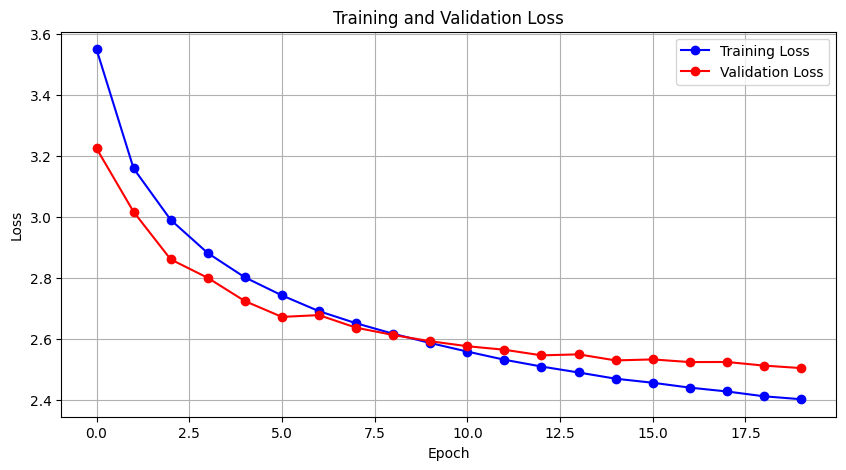

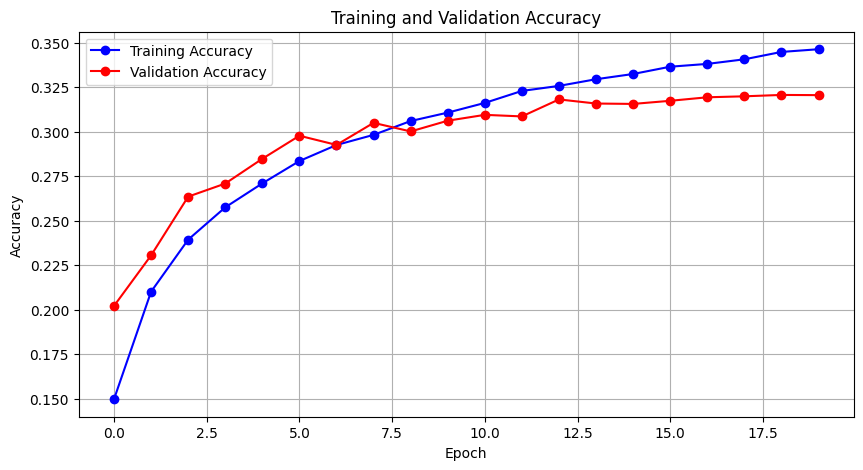

In [12]:
# extracting training and validation loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# extracting training and validation accuracy from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(val_loss, label='Validation Loss', color='red', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', color='red', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()